In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import copy as cp

In [2]:
img_path = "./14_kongarachanikya_mask.png"

In [3]:
image = cv2.imread(img_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

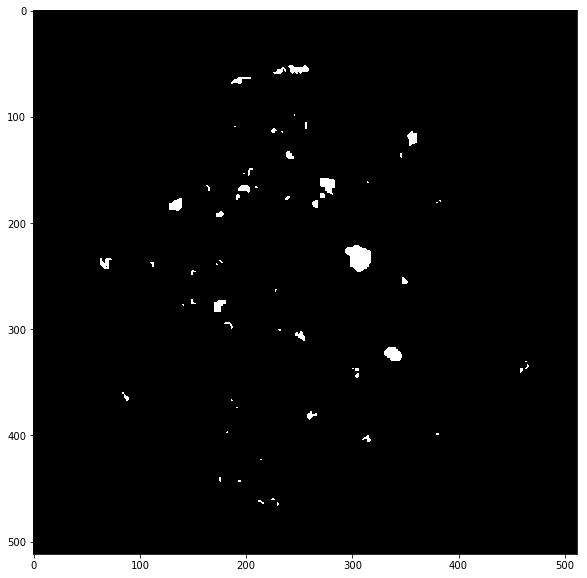

In [4]:
image_thresholded = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.figure(figsize=(10,10))
plt.imshow(image_thresholded, cmap = 'gray')

In [5]:
def fix_theta(angle, w, h):
    if w < h:
#         print("Width Less")
        inter = 90 - angle
        angle = inter + 180
    else: 
#         print("Width Greater")
        angle = -angle
        
    return angle

In [6]:
def generate_2d_gaussian(x_center = 0, 
                  y_center = 0, 
                  radius = 1, 
                  alpha = 0.2,
                  angle = 0, 
                  out_size = (256, 256)):
    
    """
    x_center: x coordinate of gaussian center
    y_center: y coordinate of gaussian center
    radius: Farthest distance from center of CC to contour
    alpha: parameter to adjust standard deviation of 2D gaussian
    angle: the angle to rotate 2D gaussian axis
    out_size: H x W of output 2D gaussian heatmap
    """
    
    ## Convert to radian
    theta = (2*np.pi*angle) / 360
    
    ## Generate rows and columns labels
    x = np.arange(0, out_size[0], dtype = int)
    y = np.arange(0, out_size[1], dtype = int)

    
    ## Generate meshgrid
    xv, yv = np.meshgrid(x, y)    
#     print(xv.shape)
#     print(yv.shape)
    
    ## Compte sigma for x and y axis
    x_sigma = radius * alpha
    y_sigma = radius * alpha * 2 
    
    
    ## Compute rotation coefficients, according to https://en.wikipedia.org/wiki/Gaussian_function
    
    a = ((np.power(np.cos(theta), 2)) / (2 * np.power(x_sigma, 2))) + \
        ((np.power(np.sin(theta), 2)) / (2 * np.power(y_sigma, 2)))
    
    b = -(np.sin(2 * theta) / (4 * np.power(x_sigma, 2))) + \
         (np.sin(2 * theta) / (4 * np.power(y_sigma, 2)))
    
    c = ((np.power(np.sin(theta), 2)) / (2 * np.power(x_sigma, 2))) + \
        ((np.power(np.cos(theta), 2)) / (2 * np.power(y_sigma, 2)))
    
    ## Generate rotated 2D gaussian map
    
    gauss_map = np.exp(-( (a*np.power(xv-x_center, 2)) + (2*b*(xv-x_center)*(yv-y_center)) + (c*np.power((yv-y_center),2))))
#     print(gauss_map.shape)
    
    return gauss_map

In [7]:
def generate_heatmap(mask, alpa):
    
    """
    mask: binary mask {0, 1}
    alpha: adjustable parameter to change the spread of 2D gaussian
    """
    
    ## List to save all gaussian CCs
    gauss_cc_list = list()
    
    ## Generate CCs
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    ## Loop through each CC
    for i in range(1, numLabels):
        
        single_CC = np.zeros_like(labels)
        single_CC = np.where(labels == i, 1, 0).astype("uint8")
        
        ## Generate contour for current CC
        single_CC_contours, _ = cv2.findContours(single_CC, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        ## Get the furthest point from center == radius of the tightest fitting square
        (x,y), radius = cv2.minEnclosingCircle(single_CC_contours[0])
        
        ## Get rotated, tightest bouding box
        _, (h, w), angle = cv2.minAreaRect(single_CC_contours[0])
        
        ## Adjust bbox angle to gaussian y-axis angle
        angle = fix_theta(angle, w, h)
        
        ## Generate 2D gaussian map for a single CC
        single_CC_map = generate_2d_gaussian(x_center = int(x), 
                                             y_center = int(y), 
                                             radius = radius, 
                                             alpha = alpa,
                                             angle = angle,
                                             out_size = single_CC.shape)
        
        gauss_cc_list.append(single_CC_map)
        
        
    ### Handle empty mask
    if len(gauss_cc_list) == 0:
        gt_map = np.zeros_like(image_thresh).astype('float32')
    else:
        gt_map = np.array(gauss_cc_list)
        gt_map = np.max(gt_map, axis = 0)
         
    assert np.max(gt_map) <= 1.0, "Probabilty must not exceed 1.0"
    assert np.min(gt_map) >= 0.0, "Probabilty must not be less than 0.0"
    assert len(np.where(gt_map == 1)[0]) == numLabels-1, "There should 1.0 at the center of each CC"
    
    return gt_map

In [8]:
gt_map = generate_heatmap(image_thresholded, 0.2)

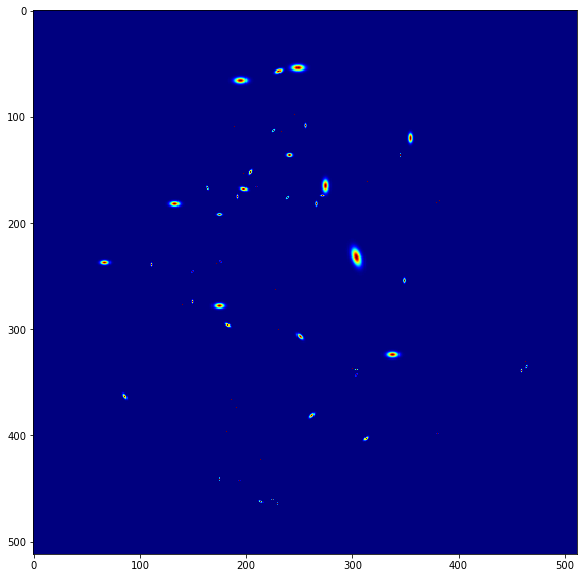

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(gt_map, cmap = 'jet')